# Active Learning Guide

TBD.

## Setup

In [1]:
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2

## Dataset

In [21]:
from torch.utils.data import DataLoader
import torchvision.transforms as T

from data_utils import (
    build_resized_image_folder,
    build_paths_and_labels,
    train_test_val_pool_split,
    CustomDataset,
    IMAGENET_MEAN,
    IMAGENET_STD,
    visualize_batch,
)

In [4]:
# Resize images to 64px their smallest side and save to new folder.
# This will accelerate training, since the purpose is to show how active learning works.
dataset_root = Path("./data/flowers")
build_resized_image_folder(
    src_root=dataset_root / "train",
    dst_root=dataset_root / "train_64",
    min_side=64,
    overwrite=False,
)

Processing images: 100%|██████████| 2751/2751 [00:03<00:00, 905.91it/s]

Done. Processed 2746 images. Wrote 0 resized images to: data\flowers\train_64


In [5]:
# Given the root path, get lists of paths and labels
paths, labels, classes, class_to_id = build_paths_and_labels(dataset_root / "train_64")

In [6]:
print(f"Number of paths: {len(paths)}")
print(f"Classes: {classes}")
print(f"Class to index mapping: {class_to_id}")
print(f"First path: {paths[0]}")
print(f"First label (int, id): {labels[0]}")
print(f"First label (str): {classes[labels[0]]}")

Number of paths: 2746
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Class to index mapping: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
First path: data\flowers\train_64\daisy\10140303196_b88d3d6cec.jpg
First label (int, id): 0
First label (str): daisy


In [7]:
# Perform stratified splitsfor train/val/test/pool
# Pool is the portion of the data which is considered "unlabeled" and can be queried for active learning.
train_idx, val_idx, test_idx, pool_idx = train_test_val_pool_split(
    labels, train_ratio=0.2, val_ratio=0.1, test_ratio=0.1, seed=42
)

In [8]:
print(f"Train size: {len(train_idx)}")
print(f"Val size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")
print(f"Pool size: {len(pool_idx)}")

Train size: 548
Val size: 276
Test size: 276
Pool size: 1646


In [16]:
# Transforms
train_transform = T.Compose([
    T.Resize((64, 64)),
    T.RandomApply([T.RandomRotation(degrees=15)], p=0.7),
    T.RandomApply([T.RandomAffine(degrees=0, translate=(0.10, 0.10))], p=0.7),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [33]:
# Auxiliary factory function to create DataLoaders
# If not Windows, set num_workers > 0 for faster data loading.
# If CUDA is available, set pin_memory=True for faster data transfer to GPU.
def make_loader(ds, batch_size=64, shuffle=False, num_workers=1, pin_memory=False):
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False,
    )

In [38]:
# Datasets and loaders
train_ds = CustomDataset(paths, labels, train_idx, transform=train_transform)
val_ds = CustomDataset(paths, labels, val_idx, transform=eval_transform)
test_ds = CustomDataset(paths, labels, test_idx,  transform=eval_transform)
pool_ds = CustomDataset(paths, labels, pool_idx, transform=eval_transform)

train_loader = make_loader(train_ds, batch_size=64, shuffle=True)
val_loader = make_loader(val_ds, batch_size=64, shuffle=False)
test_loader = make_loader(test_ds, batch_size=64, shuffle=False)
pool_loader = make_loader(pool_ds, batch_size=64, shuffle=False)

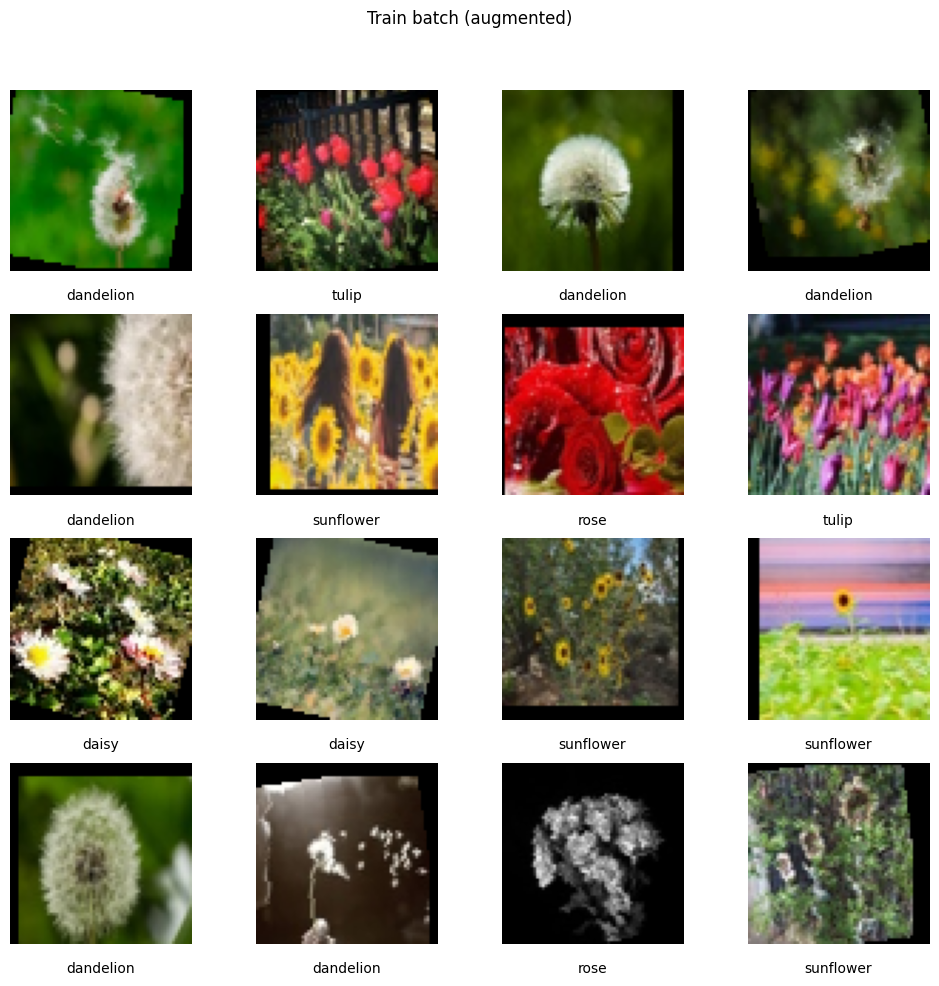

In [39]:
batch = next(iter(train_loader))
visualize_batch(batch, class_names=classes, title="Train batch (augmented)")

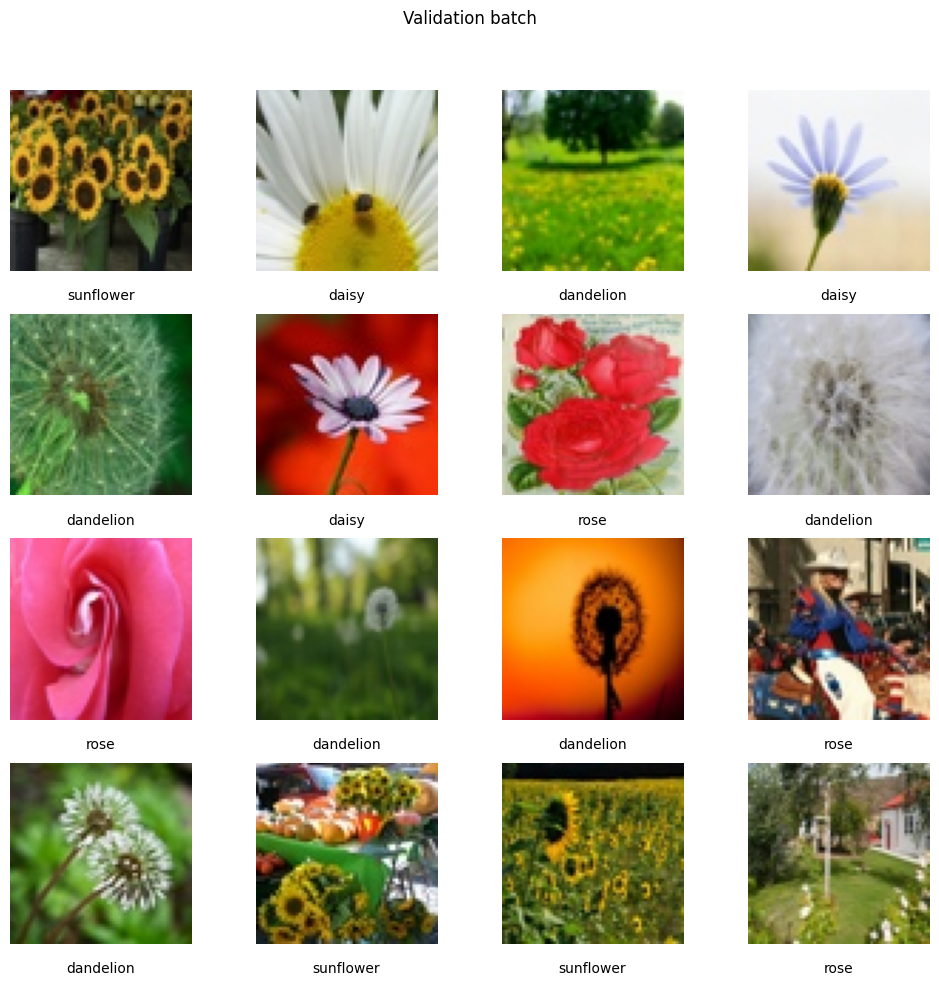

In [41]:
batch = next(iter(val_loader))
visualize_batch(batch, class_names=classes, title="Validation batch")